In [1]:
%load_ext autoreload
%autoreload 2

In [74]:
import os
import argparse
import numpy as np

import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import networkx as nx
from matplotlib import pyplot as plt

from minimal.arch import Generator

from minimal.dataset import (
    FloorplanGraphDataset,
    floorplan_collate_fn
)

from minimal.utils import (
    init_input,
    draw_masks,
    draw_graph
)

%matplotlib inline

In [3]:
PRETRAINED_PATH = "./checkpoints/pretrained.pth"
DATA_PATH = "./data/sample_list.txt"
OUT_PATH = "./dump"

os.makedirs(OUT_PATH, exist_ok=True)

In [4]:
model = Generator()
model.load_state_dict(torch.load(PRETRAINED_PATH, map_location=torch.device('cpu')), strict=True)
model = model.eval()

In [5]:
# initialize dataset iterator
fp_dataset_test = FloorplanGraphDataset(
    DATA_PATH,
    transforms.Normalize(mean=[0.5], std=[0.5]),
    split='test'
)

fp_loader = torch.utils.data.DataLoader(
    fp_dataset_test, 
    batch_size=1, 
    shuffle=False,
    collate_fn=floorplan_collate_fn
)

6


In [68]:
# run inference
def _infer(graph, model, prev_state=None):
    
    # configure input to the network
    z, given_masks_in, given_nds, given_eds = init_input(graph, prev_state)
    # run inference model
    with torch.no_grad():
        masks = model(z, given_masks_in, given_nds, given_eds)
        masks = masks.detach().cpu().numpy()
    return masks

In [61]:
i = 0
sample = next(iter(fp_loader))

In [62]:
# mks (R, 64, 64) = GT segmentation mask per room
# nds (R, 18) = one hot encoding per room
# eds (E, 3) = per edge [node_1, -1 / 1 ???, node_2]
mks, nds, eds, _, _ = sample

In [63]:
# (R,) undo one hot encoding (0-index based)
real_nodes = np.where(nds.detach().cpu()==1)[-1]
graph = [nds, eds]

In [64]:
true_graph_obj, graph_im = draw_graph([real_nodes, eds.detach().cpu().numpy()])

/home/radium/ser/follows/houseganpp/minimal/utils.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [66]:
_types = sorted(list(set(real_nodes)))
selected_types = [_types[:k+1] for k in range(10)]
print(selected_types)

[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 14], [0, 1, 2, 3, 4, 14, 16], [0, 1, 2, 3, 4, 14, 16], [0, 1, 2, 3, 4, 14, 16], [0, 1, 2, 3, 4, 14, 16]]


In [69]:
# initialize layout
state = {
    'masks': None,
    'fixed_nodes': []
}

masks = _infer(graph, model, state)

/home/radium/ser/follows/houseganpp/minimal/utils.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  given_eds = torch.tensor(given_eds).long()
/home/radium/ser/follows/houseganpp/minimal/utils.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  given_masks = torch.tensor(prev_mks)


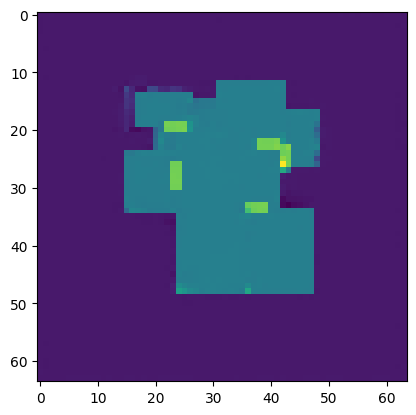

In [94]:
plt.imshow(masks.sum(0))